In [1]:
import random
import numpy as np
import scipy.io
from pyDOE import lhs

import torch
from torch import nn, optim, autograd

import torch.nn.init as init
from torch.nn import functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils_training_base import *

#Paper reproduction
random_seed_set = 1234
set_random_seed(random_seed_set)

In [2]:
N_train = 1000
N_bound = 400
N_init = 200

# Input  [x,t]
# Output [alpha, beta]

la = np.array([np.pi,1])
lb = np.array([0,0])

traindata = lb+(la-lb)*lhs(2,N_train)
x_inside = traindata[:,0:1]
t_inside = traindata[:,1:2]

x_inside = numpy_to_tensor(x_inside, var_name="x_inside", value_range_dim = True, to_torch = True, to_cuda = True, requires_grad = True)
t_inside = numpy_to_tensor(t_inside, var_name="t_inside", value_range_dim = True, to_torch = True, to_cuda = True, requires_grad = True)

x_bound = lb[0]+(la[0]-lb[0])*lhs(1,N_bound)
x_bound_t_zero = np.zeros_like(x_bound)
t_bound = lb[1]+(la[1]-lb[1])*lhs(1,N_init)


x_bound = numpy_to_tensor(x_bound, var_name="x_bound", value_range_dim = True, to_torch = True, to_cuda = True, requires_grad = True)
x_bound_t_zero = numpy_to_tensor(x_bound_t_zero, var_name="x_bound_t_zero", value_range_dim = True, to_torch = True, to_cuda = True, requires_grad = True)
t_bound = numpy_to_tensor(t_bound, var_name="t_bound", value_range_dim = True, to_torch = True, to_cuda = True, requires_grad = True)

x_inside: Column 0: range from 0.000601676098329883 to 3.141448820491793
t_inside: Column 0: range from 0.0006221087710398319 to 0.9998795647581709
x_bound: Column 0: range from 0.002011130765297697 to 3.1339553969820386
x_bound_t_zero: Column 0: range from 0.0 to 0.0
t_bound: Column 0: range from 0.0031771598660592128 to 0.997403185889695


In [3]:
# Exact solution of alpha
def exact_alpha(data_input):
    x_input = data_input[:,0:1]
    t_input = data_input[:,1:2]
    return (np.pi / 2 * np.cos(x_input) + (x_input - np.pi / 2)) * np.cos(t_input)

# Exact solution of beta
def exact_beta(data_input):
    x_input = data_input[:,0:1]
    t_input = data_input[:,1:2]
    return (np.pi / 2) * np.sin(x_input) * np.cos(t_input)

In [4]:
x_exact = np.linspace(0, np.pi, 100).reshape(-1,1)

t_exact = np.linspace(0, 1, 100).reshape(-1,1)

print('t_exact:', t_exact.shape)
print('x_exact:', x_exact.shape)

t_exact: (100, 1)
x_exact: (100, 1)


In [5]:
X_exact, T_exact = np.meshgrid(x_exact, t_exact)
print('X_exact:', X_exact.shape)
print('T_exact:', T_exact.shape)

X_exact_flatten = X_exact.flatten()[:, None]
T_exact_flatten = T_exact.flatten()[:, None]
data_star = np.hstack((X_exact_flatten, T_exact_flatten))

alpha_star = exact_alpha(data_star)
Exact_alpha = alpha_star.reshape(X_exact.shape)

beta_star = exact_beta(data_star)
Exact_beta = beta_star.reshape(X_exact.shape)

X_exact: (100, 100)
T_exact: (100, 100)


In [6]:
data_star.shape

(10000, 2)

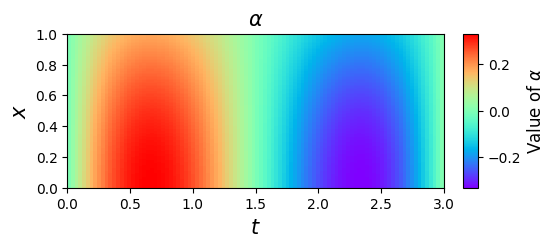

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 2))

cmap = plt.get_cmap('jet')
heatmap1 = ax1.imshow(Exact_alpha,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[0, 3, 0, 1],
                      origin='lower',
                      aspect='auto')

ax1.set_title(r'$\alpha$', fontsize=15)
ax1.set_xlabel(r'$t$', fontsize=15)
ax1.set_ylabel(r'$x$', fontsize=15)

# Add a color bar
cbar = fig.colorbar(heatmap1, ax=ax1, fraction=0.15, pad=0.04, aspect=10)
cbar.set_label(r'Value of $\alpha$', fontsize=12)

plt.show()

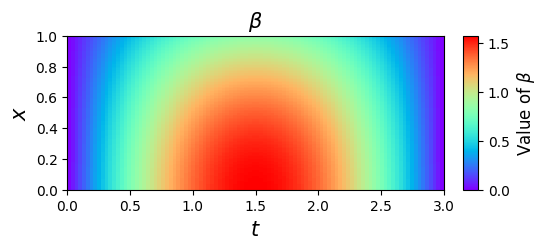

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 2))

cmap = plt.get_cmap('jet')
heatmap1 = ax1.imshow(Exact_beta,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[0, 3, 0, 1],
                      origin='lower',
                      aspect='auto')

ax1.set_title(r'$\beta$', fontsize=15)
ax1.set_xlabel(r'$t$', fontsize=15)
ax1.set_ylabel(r'$x$', fontsize=15)

# Add a color bar
cbar = fig.colorbar(heatmap1, ax=ax1, fraction=0.15, pad=0.04, aspect=10)
cbar.set_label(r'Value of $\beta$', fontsize=12)

plt.show()

In [9]:
random_seed = 1234
np.random.seed(random_seed)

# Input  [x,t]
# Output [alpha, beta]

x_values = [0.2, 0.8, 1.8, 2.6, 3.0]
observe_number_per_x = 10

observe_data = []
for x in x_values:
    t_for_x = lhs(1, observe_number_per_x)
    x_column = np.full((observe_number_per_x, 1), x)
    observe_data_x_t = np.hstack((x_column, t_for_x))
    observe_data.append(observe_data_x_t)

observe_data = np.vstack(observe_data)

observe_clear_alpha = exact_alpha(observe_data)
observe_clear_deta = exact_beta(observe_data)
observe_clear_u = np.hstack((observe_clear_alpha, observe_clear_deta))

noise_nu = 0.02
noise_std = 0.05
noise_u = np.random.normal(loc=noise_nu, scale=noise_std, size=observe_clear_u.shape)
observe_u = observe_clear_u + noise_u

observe_data = numpy_to_tensor(observe_data,
                               var_name="observe_data",
                               value_range_dim=True,
                               to_torch=True,
                               to_cuda=True,
                               requires_grad=True)

observe_clear_u = numpy_to_tensor(observe_clear_u,
                                  var_name="observe_u",
                                  value_range_dim=True,
                                  to_torch=True,
                                  to_cuda=True,
                                  requires_grad=True)

observe_u = numpy_to_tensor(observe_u,
                            var_name="observe_u",
                            value_range_dim=True,
                            to_torch=True,
                            to_cuda=True,
                            requires_grad=True)

observe_data_x_inside = observe_data[:, 0:1]
observe_data_t_inside = observe_data[:, 1:2]

observe_data: Column 0: range from 0.2 to 3.0
observe_data: Column 1: range from 0.01915194503788923 to 0.9933140101982522
observe_u: Column 0: range from -0.316500995941234 to 0.32307859090056074
observe_u: Column 1: range from 0.13416276268443897 to 1.5272364713454367
observe_u: Column 0: range from -0.3907741166429186 to 0.43592035249088634
observe_u: Column 1: range from 0.082715509608204 to 1.6068378393113447


In [10]:
np.random.seed(5678)
N_test_number = 10000

test_data = lb + (la - lb) * lhs(2, N_test_number)
test_alpha = exact_alpha(test_data)
test_deta = exact_beta(test_data)
test_u = np.concatenate((test_alpha, test_deta), axis=1)

test_data = numpy_to_tensor(test_data,
                            var_name="test_data",
                            value_range_dim=True,
                            to_torch=True,
                            to_cuda=True,
                            requires_grad=True)

test_u = numpy_to_tensor(test_u,
                         var_name="test_u",
                         value_range_dim=True,
                         to_torch=True,
                         to_cuda=True,
                         requires_grad=True)

test_data_x_inside = test_data[:, 0:1]
test_data_t_inside = test_data[:, 1:2]

test_data: Column 0: range from 0.00015372660456055158 to 3.141307348425438
test_data: Column 1: range from 5.933244265166393e-06 to 0.9999791490405054
test_u: Column 0: range from -0.33061157677273223 to 0.3306427744135542
test_u: Column 1: range from 0.00016703260357809924 to 1.5707671842890616


In [11]:
print('The number of observational data J:', len(observe_u))

The number of observational data J: 50


In [12]:
def get_loss_f_1(x_grad, t_grad, PINNs, C, return_sequence='not'):
    
    E_inside = PINNs(torch.cat((x_grad,t_grad),dim=1))
    
    E_alpha = E_inside[:,0:1]
    E_beta = E_inside[:,1:2]

    alpha_tt = compute_higher_order_derivatives(E_alpha, [t_grad,t_grad])
    alpha_x = compute_higher_order_derivatives(E_alpha, [x_grad])
    alpha_xx = compute_higher_order_derivatives(alpha_x, [x_grad])
    
    beta_tt = compute_higher_order_derivatives(E_beta, [t_grad,t_grad])
    beta_x = compute_higher_order_derivatives(E_beta, [x_grad])
    beta_xx = compute_higher_order_derivatives(beta_x, [x_grad])
    
    g = torch.cos(t_grad) - torch.pi/2 * torch.sin(x_grad) * torch.cos(t_grad)
    
    loss_f_1_sequence = C * alpha_tt - alpha_xx + (E_alpha - beta_x)
    loss_f_1_squared_sequence = torch.square(loss_f_1_sequence)

    loss_f_2_sequence = beta_tt + alpha_x - beta_xx - g
    loss_f_2_squared_sequence = torch.square(loss_f_2_sequence)

    if return_sequence == 'yes':
        return loss_f_1_squared_sequence, loss_f_2_squared_sequence
    else:
        return torch.mean(loss_f_1_squared_sequence) + torch.mean(loss_f_2_squared_sequence)

In [13]:
def get_loss_bound_1(x_bound_input, x_bound_t_zero_input, t_bound_input, PINNs, C):

    E_bound_x_zero = PINNs(torch.cat((x_bound_input,x_bound_t_zero_input),axis=1))# u(x,0)
    
    alpha_bound_x_zero = E_bound_x_zero[:,0:1]  # alpha(x,0)
    alpha_bound_x_zero_dt = compute_higher_order_derivatives(alpha_bound_x_zero, 
                                                            [x_bound_t_zero_input]) # alpha_t(x,0)

    beta_bound_x_zero = E_bound_x_zero[:,1:2] # beta(x,0)
    beta_bound_x_zero_dt = compute_higher_order_derivatives(beta_bound_x_zero, 
                                                     [x_bound_t_zero_input]) # beta_t(x,0)
        
    loss_bound_x_a = alpha_bound_x_zero-(torch.pi/2)*torch.cos(x_bound_input)-(x_bound_input-torch.pi/2)
    loss_bound_x_b = alpha_bound_x_zero_dt-torch.zeros_like(alpha_bound_x_zero_dt)
    loss_bound_x_c = beta_bound_x_zero-(torch.pi/2)*torch.sin(x_bound_input)
    loss_bound_x_d = beta_bound_x_zero_dt-torch.zeros_like(beta_bound_x_zero_dt)
    
    loss_bound_x = torch.mean(torch.square(loss_bound_x_a))+\
                   torch.mean(torch.square(loss_bound_x_b))+\
                   torch.mean(torch.square(loss_bound_x_c))+\
                   torch.mean(torch.square(loss_bound_x_d))
 
    E_bound_zero_t = PINNs(torch.cat((torch.zeros_like(t_bound_input),t_bound_input),axis=1)) #u(0,t)
    alpha_zero_t = E_bound_zero_t[:,0:1]  # alpha(0,t)
    beta_t = E_bound_zero_t[:,1:2] # beta(0,t)
    
    E_bound_pi_t = PINNs(torch.cat((torch.ones_like(t_bound_input)*torch.pi,t_bound_input),axis=1)) #u(pi,t)
    alpha_pi_t = E_bound_pi_t[:,0:1]  # alpha(pi,t)
    beta_pi_t = E_bound_pi_t[:,1:2] # beta(pi,t)
    
    loss_bound_t = torch.mean(torch.square(alpha_zero_t))+\
                   torch.mean(torch.square(beta_t))+\
                   torch.mean(torch.square(alpha_pi_t))+\
                   torch.mean(torch.square(beta_pi_t))
    
    loss_bound_value = loss_bound_x+loss_bound_t
    
    return loss_bound_value

In [14]:
x_inside_all = torch.cat((x_inside,observe_data[:,0:1]),dim=0)
t_inside_all = torch.cat((t_inside,observe_data[:,1:2]),dim=0)

In [15]:
data_inputs = {
    'x_inside_all': x_inside_all,
    't_inside_all': t_inside_all,
    'x_inside': x_inside,
    't_inside': t_inside,
    'x_bound' : x_bound,
    'x_bound_t_zero' : x_bound_t_zero,
    't_bound' : t_bound,
    'observe_data': observe_data,
    'observe_u': observe_u,
    'observe_clear_u': observe_clear_u,
    'observe_data_x_inside': observe_data_x_inside,
    'observe_data_t_inside': observe_data_t_inside,
    'test_data': test_data,
    'test_u': test_u,
    'test_data_x_inside': test_data_x_inside,
    'test_data_t_inside': test_data_t_inside,
    'C1': None,
}

In [16]:
#Paper reproduction
random_seed_set = 1234
set_random_seed(random_seed_set)

In [17]:
net_settings_for_PINNs_1 = NetSetting(input_dims=2,
                                     hidden_neurons_list=[50] * 4,
                                     output_dims=2,
                                     hidden_activation='tanh',
                                     output_activation=None,
                                     initializer_method='xavier')

PINNs_1 = get_mlp_pinn(net_settings_for_PINNs_1)
PINNs_1.cuda()

initialize_weights(PINNs_1, net_settings_for_PINNs_1.initializer_method)

optimizer1 = optim.Adam(PINNs_1.parameters(),
                        lr=0.001,
                        betas=(0.9, 0.999),
                        eps=1e-08,
                        weight_decay=0,
                        amsgrad=False)

C1 = torch.tensor(0.0, requires_grad=True)
optimizer1.add_param_group({'params': [C1], 'lr': 0.001})

In [18]:
nIter1 = 20000
it = 0
training_recorder_1 = training_recorder()

best_loss_all = 100
best_test_loss = 100 

while it < nIter1:
    #########loss f#########
    loss_f = get_loss_f_1(x_inside_all, t_inside_all, PINNs_1, C1)
   
    #########loss bound#########
    loss_bound = get_loss_bound_1(x_bound, x_bound_t_zero, t_bound, PINNs_1, C1)

    #########loss T noisy observation#########
    E_observation = PINNs_1(observe_data)
    loss_T_observation_noisy = torch.mean(torch.square(E_observation - observe_u))
    
    #########loss PI#########
    loss_all = loss_f + loss_bound + 10 * loss_T_observation_noisy 

    data_inputs['C1'] = C1
    test_loss  = training_calculator(PINNs_1, get_loss_f_1,
                                     training_recorder_1, data_inputs)
    
    if it % 1000 == 0:
        print(f"Iterations: {it}, train_loss: {loss_all.item():.8f}, test_loss: {test_loss:.6f}")
        print('Estimated parameter:',C1)
    
    optimizer1.zero_grad()
    loss_all.backward()
    optimizer1.step()
    
    it = it + 1
    
print(f"Final result: train_loss: {loss_all.item():.8f}, test_loss: {test_loss:.6f}")
print('Estimated parameter:',C1)

output_dir = '../experimental_data/Timoshenko_beam/original_N2/'
training_recorder_1.save(output_dir)

Iterations: 0, train_loss: 3.28279328, test_loss: 0.751280
Estimated parameter: tensor(0., requires_grad=True)
Iterations: 1000, train_loss: 0.02992282, test_loss: 0.028394
Estimated parameter: tensor(0.6552, requires_grad=True)
Iterations: 2000, train_loss: 0.02905783, test_loss: 0.027224
Estimated parameter: tensor(0.9213, requires_grad=True)
Iterations: 3000, train_loss: 0.02881717, test_loss: 0.026961
Estimated parameter: tensor(0.9969, requires_grad=True)
Iterations: 4000, train_loss: 0.02868081, test_loss: 0.027108
Estimated parameter: tensor(1.0206, requires_grad=True)
Iterations: 5000, train_loss: 0.02858897, test_loss: 0.026592
Estimated parameter: tensor(1.0303, requires_grad=True)
Iterations: 6000, train_loss: 0.02848508, test_loss: 0.027583
Estimated parameter: tensor(1.0353, requires_grad=True)
Iterations: 7000, train_loss: 0.02840217, test_loss: 0.027679
Estimated parameter: tensor(1.0399, requires_grad=True)
Iterations: 8000, train_loss: 0.02830858, test_loss: 0.027439
E